# Set up

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
from itertools import combinations

import warnings

from sklearn.utils import resample
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score 
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import preprocessing

import xgboost as xgb
import lightgbm as lgb

np.random.seed(42)

# Import data

In [2]:
df = pd.read_excel('C:/Users/14702/OneDrive/Desktop/Emory/Machine Learning II/Assignment#4/training data.xlsx')
# show the first 5 rows of the dataset
df.head()

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter,user_id
0,24,0,20,26.333333,0.777778,6,0,37804,4,20,...,54,0,0,0,0,79,0,0,0,10
1,29,1,12,26.900000,0.818182,6,1,15955,19,4,...,802,0,0,0,1,80,0,0,0,58
2,22,0,4,21.000000,1.000000,2,0,31441,7,0,...,0,0,0,0,0,53,0,0,0,72
3,27,0,1,29.000000,1.000000,1,0,0,0,0,...,0,0,0,0,0,59,0,0,0,121
4,22,1,4,21.250000,0.750000,1,0,774,0,0,...,0,0,0,0,0,60,0,0,0,137


In [3]:
# It's an inbalanced dataset
print(df.adopter.value_counts())

0    85142
1     1540
Name: adopter, dtype: int64


In [4]:
# split 1&0 data
data_0 = df[df['adopter'] == 0]
data_1 = df[df['adopter'] == 1]

# resample the minority dataset
data_1_upsample = resample(data_1,replace=True,n_samples=data_0.shape[0],random_state=42) 
 
# combine two datasets back together
df_resample = pd.concat([data_1_upsample, data_0])
 
# show the new dataset
print(df_resample.adopter.value_counts())
df_resample.head()

1    85142
0    85142
Name: adopter, dtype: int64


,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter,user_id
65306,23,1,6,24.4,0.666667,2,0,11963,14,0,...,2076,0,0,0,0,38,1,0,1,1288636
82912,18,1,1,28.0,1.000000,1,0,20609,21,0,...,14705,1,0,0,0,5,1,0,1,1636899
52115,28,1,11,26.5,0.555556,5,0,28559,127,2,...,2563,4,0,0,1,57,1,0,1,1026354
74316,24,1,58,24.0,0.791667,15,3,58531,1316,3,...,1558,1,0,0,0,48,0,0,1,1466854
65524,35,1,3,28.5,0.000000,1,0,25551,44,15,...,1480,1,0,0,0,73,0,0,1,1293189


In [9]:
# retrieving attributes
y = df_resample.values[:,-2]
X = df_resample.values[:,:-2]

# normalization 
# sc = StandardScaler()
# sc.fit(X)
# X = sc.transform(X)

In [10]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [49]:
df_test = pd.read_excel('C:/Users/14702/OneDrive/Desktop/Emory/Machine Learning II/Assignment#4/test data.xlsx')
# show the first 5 rows of the dataset
df_test.head()
# retrieving predictive variables
X_pred = df_test.values[:,:-1]

In [11]:
# we want to use cross validation to tuning parameters
inner_cv = KFold(n_splits=5, shuffle=True,random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True,random_state=42)

In [8]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Function to calculate accuracy and plot confusion matrix 
def cal_accuracy(y_test, y_pred): 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,classes=["1","0"],
                      title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["1","0"], normalize=True,
                      title='Normalized confusion matrix')
    
    plt.show()

# XGBoost

In [13]:
########################################## XGBoost ##################################################

# Parameter tuning: 'max_depth' and 'min_child_weight'

param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gs_xgb = GridSearchCV(
    estimator = XGBClassifier(seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv,
    n_jobs=-1)

gs_xgb = gs_xgb.fit(X_train,y_train)  
print("XGBoost Parameter Tuning")
print("Non-nested CV F1-score: ", gs_xgb.best_score_)
print("Optimal Parameter: ", gs_xgb.best_params_)
print("Optimal Estimator: ", gs_xgb.best_estimator_) 

XGBoost Parameter Tuning
Non-nested CV F1-score:  0.959695232065527
Optimal Parameter:  {'max_depth': 9, 'min_child_weight': 5}
Optimal Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=None, subsample=1,
       verbosity=1)


In [14]:
########################################## XGBoost ##################################################

# Parameter tuning: 'max_depth' and 'min_child_weight'

param_test = {
 'max_depth':[8,9,10],
 'min_child_weight':[4,5,6]
}

gs_xgb = GridSearchCV(
    estimator = XGBClassifier(seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv,
    n_jobs=-1)

gs_xgb = gs_xgb.fit(X_train,y_train)  
print("XGBoost Parameter Tuning")
print("Non-nested CV F1-score: ", gs_xgb.best_score_)
print("Optimal Parameter: ", gs_xgb.best_params_)
print("Optimal Estimator: ", gs_xgb.best_estimator_) 

XGBoost Parameter Tuning
Non-nested CV F1-score:  0.9740735845549127
Optimal Parameter:  {'max_depth': 10, 'min_child_weight': 5}
Optimal Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=None, subsample=1,
       verbosity=1)


In [15]:
########################################## XGBoost ##################################################

# Parameter tuning: 'max_depth' and 'min_child_weight'

param_test = {
'gamma':[i/10.0 for i in range(0,5)]
}

gs_xgb = GridSearchCV(
    estimator = XGBClassifier(max_depth=10, min_child_weight=5, seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv,
    n_jobs=-1)

gs_xgb = gs_xgb.fit(X_train,y_train)  
print("XGBoost Parameter Tuning")
print("Non-nested CV F1-score: ", gs_xgb.best_score_)
print("Optimal Parameter: ", gs_xgb.best_params_)
print("Optimal Estimator: ", gs_xgb.best_estimator_) 

XGBoost Parameter Tuning
Non-nested CV F1-score:  0.9746116508928809
Optimal Parameter:  {'gamma': 0.4}
Optimal Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.4,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
       subsample=1, verbosity=1)


Accuracy :  97.28983762515783
Report :                precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     17106
         1.0       0.95      1.00      0.97     16951

   micro avg       0.97      0.97      0.97     34057
   macro avg       0.97      0.97      0.97     34057
weighted avg       0.97      0.97      0.97     34057

Confusion matrix, without normalization
[[16189   917]
 [    6 16945]]
Normalized confusion matrix
[[9.46e-01 5.36e-02]
 [3.54e-04 1.00e+00]]


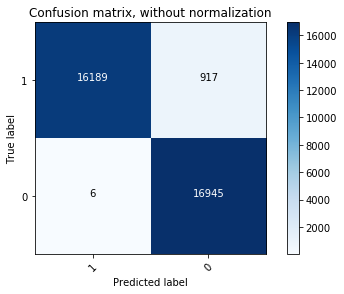

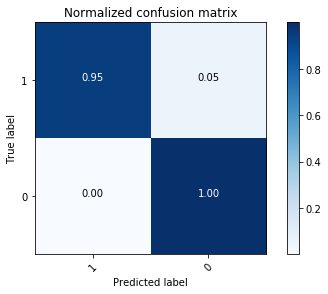

None


In [20]:
# make prediction on test dataset
y_pred = gs_xgb.predict(X_test) 

# calculate accuracy and plot confusion matrix
print(cal_accuracy(y_test, y_pred))  

In [21]:
# get generalized performance for further comparation
f1_score = cross_val_score(gs_xgb.best_estimator_, X_test, y_test, cv=outer_cv, scoring='f1')
np.mean(f1_score)

0.9453399604151815

In [25]:
# make a final prediction
y_pred = gs_xgb.best_estimator_.predict(X_pred) 

y_pred = y_pred.astype('int64')

# LightGBM

In [16]:
########################################## LightGBM ##################################################

# Parameter tuning: 'max_depth' and 'num_leaves'

warnings.filterwarnings('ignore')

param_test = {
    'max_depth': range(3,8,2),
    'num_leaves':range(50,170,30)
}

gs_lgb = GridSearchCV(
    estimator = LGBMClassifier(seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_lgb = gs_lgb.fit(X_train,y_train)  
print("LightGBM Parameter Tuning")
print("Non-nested CV F1-score: ", gs_lgb.best_score_)
print("Optimal Parameter: ", gs_lgb.best_params_)
print("Optimal Estimator: ", gs_lgb.best_estimator_) 

LightGBM Parameter Tuning
Non-nested CV F1-score:  0.9103947075770751
Optimal Parameter:  {'max_depth': 7, 'num_leaves': 140}
Optimal Estimator:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=140, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)


In [17]:
########################################## LightGBM ##################################################

# Parameter tuning: 'max_depth' and 'num_leaves'

warnings.filterwarnings('ignore')

param_test = {
     'max_depth': [6,7,8,9],
    'num_leaves':(130,150,2)
}

gs_lgb = GridSearchCV(
    estimator = LGBMClassifier(seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_lgb = gs_lgb.fit(X_train,y_train)  
print("LightGBM Parameter Tuning")
print("Non-nested CV F1-score: ", gs_lgb.best_score_)
print("Optimal Parameter: ", gs_lgb.best_params_)
print("Optimal Estimator: ", gs_lgb.best_estimator_) 

LightGBM Parameter Tuning
Non-nested CV F1-score:  0.956540876490158
Optimal Parameter:  {'max_depth': 9, 'num_leaves': 150}
Optimal Estimator:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=9,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=150, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)


In [19]:
########################################## LightGBM ##################################################

# Parameter tuning: 'max_depth' and 'num_leaves'

warnings.filterwarnings('ignore')

param_test = {
    'min_child_samples': [22, 23, 24, 25, 26],
    'min_child_weight':[0.001, 0.002]
}

gs_lgb = GridSearchCV(
    estimator = LGBMClassifier(max_depth=9, num_leaves=150, seed=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_lgb = gs_lgb.fit(X_train,y_train)  
print("LightGBM Parameter Tuning")
print("Non-nested CV F1-score: ", gs_lgb.best_score_)
print("Optimal Parameter: ", gs_lgb.best_params_)
print("Optimal Estimator: ", gs_lgb.best_estimator_) 

LightGBM Parameter Tuning
Non-nested CV F1-score:  0.9594218377276339
Optimal Parameter:  {'min_child_samples': 22, 'min_child_weight': 0.001}
Optimal Estimator:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=9,
        min_child_samples=22, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=150, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)


Accuracy :  95.69251548873947
Report :                precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     17106
         1.0       0.92      0.99      0.96     16951

   micro avg       0.96      0.96      0.96     34057
   macro avg       0.96      0.96      0.96     34057
weighted avg       0.96      0.96      0.96     34057

Confusion matrix, without normalization
[[15736  1370]
 [   97 16854]]
Normalized confusion matrix
[[0.92 0.08]
 [0.01 0.99]]


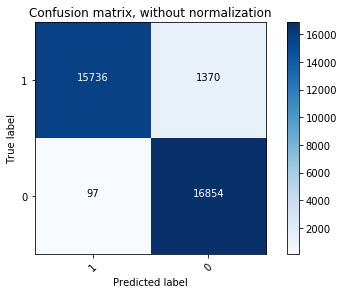

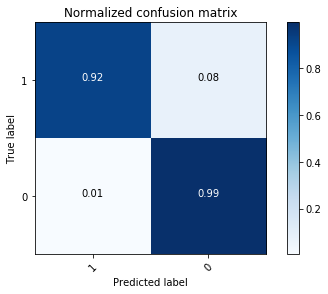

None


In [30]:
# make prediction on test dataset
y_pred = gs_lgb.predict(X_test) 

# calculate accuracy and plot confusion matrix
print(cal_accuracy(y_test, y_pred))  

In [31]:
# get generalized performance for further comparation
f1_score = cross_val_score(gs_lgb.best_estimator_, X_test, y_test, cv=outer_cv, scoring='f1')
np.mean(f1_score)

0.9378526672923476

In [32]:
# make a final prediction
y_pred = gs_lgb.best_estimator_.predict(X_pred) 

y_pred = y_pred.astype('int64')

# Random Forest

In [37]:
########################################## Random Forest ##################################################

# Parameter tuning: 'n_estimators', 'max_depth' and 'min_samples_split'

warnings.filterwarnings('ignore')

param_test = {
    'n_estimators':range(10,71,10),
    'max_depth':range(3,14,2), 
    'min_samples_split':range(50,201,20)
}

gs_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_rf = gs_rf.fit(X_train,y_train)  
print("Random Forest Parameter Tuning")
print("Non-nested CV F1-score: ", gs_rf.best_score_)
print("Optimal Parameter: ", gs_rf.best_params_)
print("Optimal Estimator: ", gs_rf.best_estimator_) 

Random Forest Parameter Tuning
Non-nested CV F1-score:  0.9409602065127706
Optimal Parameter:  {'max_depth': 13, 'min_samples_split': 50, 'n_estimators': 60}
Optimal Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [38]:
########################################## Random Forest ##################################################

# Parameter tuning: 'max_depth' and 'min_samples_split'

warnings.filterwarnings('ignore')

param_test = {
    'max_depth':[12,13,14,15,16,17], 
    'min_samples_split': range(30,50,2)
}

gs_rf = GridSearchCV(
    estimator = RandomForestClassifier(n_estimators = 60, random_state=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_rf = gs_rf.fit(X_train,y_train)  
print("Random Forest Parameter Tuning")
print("Non-nested CV F1-score: ", gs_rf.best_score_)
print("Optimal Parameter: ", gs_rf.best_params_)
print("Optimal Estimator: ", gs_rf.best_estimator_) 

Random Forest Parameter Tuning
Non-nested CV F1-score:  0.9811916357635053
Optimal Parameter:  {'max_depth': 17, 'min_samples_split': 30}
Optimal Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [39]:
########################################## Random Forest ##################################################

# Parameter tuning: 'max_features'

warnings.filterwarnings('ignore')

param_test = {
    'max_features':range(3,11,2)
}

gs_rf = GridSearchCV(
    estimator = RandomForestClassifier(max_depth = 17, min_samples_split = 30, n_estimators = 60, random_state=42), 
    param_grid = param_test, 
    scoring='f1',
    cv=inner_cv)

gs_rf = gs_rf.fit(X_train,y_train)  
print("Random Forest Parameter Tuning")
print("Non-nested CV F1-score: ", gs_rf.best_score_)
print("Optimal Parameter: ", gs_rf.best_params_)
print("Optimal Estimator: ", gs_rf.best_estimator_) 

Random Forest Parameter Tuning
Non-nested CV F1-score:  0.9823365082502469
Optimal Parameter:  {'max_features': 3}
Optimal Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


Accuracy :  98.38799659394545
Report :                precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     17106
         1.0       0.97      1.00      0.98     16951

   micro avg       0.98      0.98      0.98     34057
   macro avg       0.98      0.98      0.98     34057
weighted avg       0.98      0.98      0.98     34057

Confusion matrix, without normalization
[[16568   538]
 [   11 16940]]
Normalized confusion matrix
[[9.69e-01 3.15e-02]
 [6.49e-04 9.99e-01]]


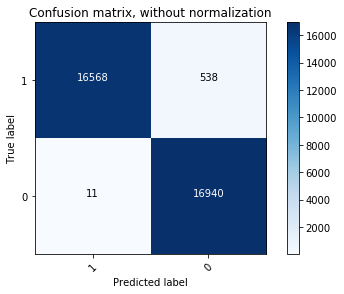

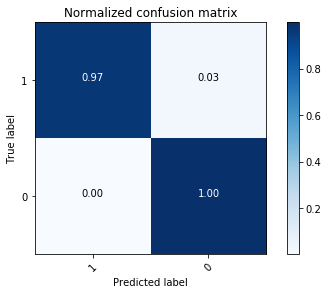

None


In [40]:
# make prediction on test dataset
y_pred = gs_rf.predict(X_test) 

# calculate accuracy and plot confusion matrix
print(cal_accuracy(y_test, y_pred))  

In [41]:
# get generalized performance for further comparation
f1_score = cross_val_score(gs_rf.best_estimator_, X_test, y_test, cv=outer_cv, scoring='f1')
np.mean(f1_score)

0.9369809644946928

In [42]:
# make a final prediction
y_pred = gs_rf.best_estimator_.predict(X_pred) 

y_pred = y_pred.astype('int64')

# Compare three models

ROC AUC: 0.999 (+/- 0.000) [XGBoost]
ROC AUC: 0.995 (+/- 0.001) [LightGBM]
ROC AUC: 1.000 (+/- 0.000) [Random Forest]


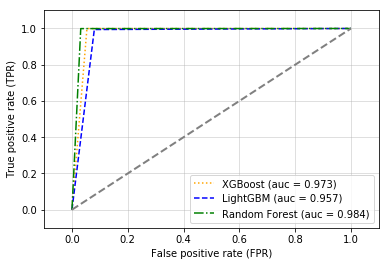

In [46]:
# Label the classifiers
clf_labels = ['XGBoost', 'LightGBM','Random Forest']
all_clf = [gs_xgb.best_estimator_, gs_lgb.best_estimator_, gs_rf.best_estimator_]

# calculate AUC
for clf, label in zip([gs_xgb.best_estimator_, gs_lgb.best_estimator_, gs_rf.best_estimator_], clf_labels): #For all classifiers 
    scores = cross_val_score(estimator=clf,  #Estimate AUC based on cross validation
                             X=X,
                             y=y,
                             cv=5,
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

# visualization   
colors = [ 'orange', 'blue', 'green']      # Colors for visualization
linestyles = [':', '--', '-.', '-']        # Line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test) 
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

# According to generalized performance and ROC-AUC score, I decided to use Random Forest as my final model

# Make Final Prediction

In [47]:
# Random Forest prediction
y_pred = gs_rf.best_estimator_.predict(X_pred) 
y_pred = y_pred.astype('int64')

In [48]:
# Write the outcomes

df_pred = pd.DataFrame(y_pred)

user_id = df_test[['user_id']].values
user_id = user_id.astype('float')
user_id = pd.DataFrame(user_id)

df_pred = pd.concat( [user_id, df_pred], axis=1 )
df_pred.columns = ['user_id','prediction(adopter)']

df_pred.dtypes

# export predictions 
df_pred.to_csv('C:/Users/14702/OneDrive/Desktop/Emory/Machine Learning II/Assignment#4/predictions.csv',index=False)

In [43]:
sum(y_pred)

2901